In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image

In [4]:
weights_path = '/kaggle/input/weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = InceptionV3(include_top=False, pooling='avg', weights=weights_path)
print(model.summary())

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [5]:
directory = "/kaggle/input/flickr-8k-images-with-captions/Images"
features = {}

for img_name in tqdm(os.listdir(directory)):

    # load the image from file
    img_path = os.path.join(directory, img_name)

    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
          image = load_img(img_path, target_size=(299, 299))
          # convert image pixels to numpy array
          image = img_to_array(image)
          # reshape data for model
          image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
          # preprocess image for vgg
          image = preprocess_input(image)
          # extract features
          feature = model.predict(image, verbose=0)
          # get image id
          image_id = img_name.split('.')[0]
          # store feature
          features[image_id] = feature
        except Exception as e:
          print(f"Error processing image {img_name}: {e}")


  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1726482800.484078   68211 service.cc:145] XLA service 0x78719c002580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726482800.484126   68211 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726482800.484132   68211 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726482805.314523   68211 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join("/kaggle/working/", 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join("/kaggle/working/", 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption  = tokens[0], tokens[1:]
    # remove extension from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            caption = caption.lower()  #convert to lowercase
            caption = caption.replace('[^A-Za-z]', '')  #delete special chars,digit
            caption = caption.replace('\s+', ' ')  #multiple space remove to single space
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'  #add start and end tags to the caption
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [31]:
# Save the tokenizer
with open('/kaggle/working/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [32]:
# Load the tokenizer
with open('/kaggle/working/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [19]:
vocab_size

8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    # total_samples = len(data_keys)
    # while n < total_samples:
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence (onehotencoding)
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

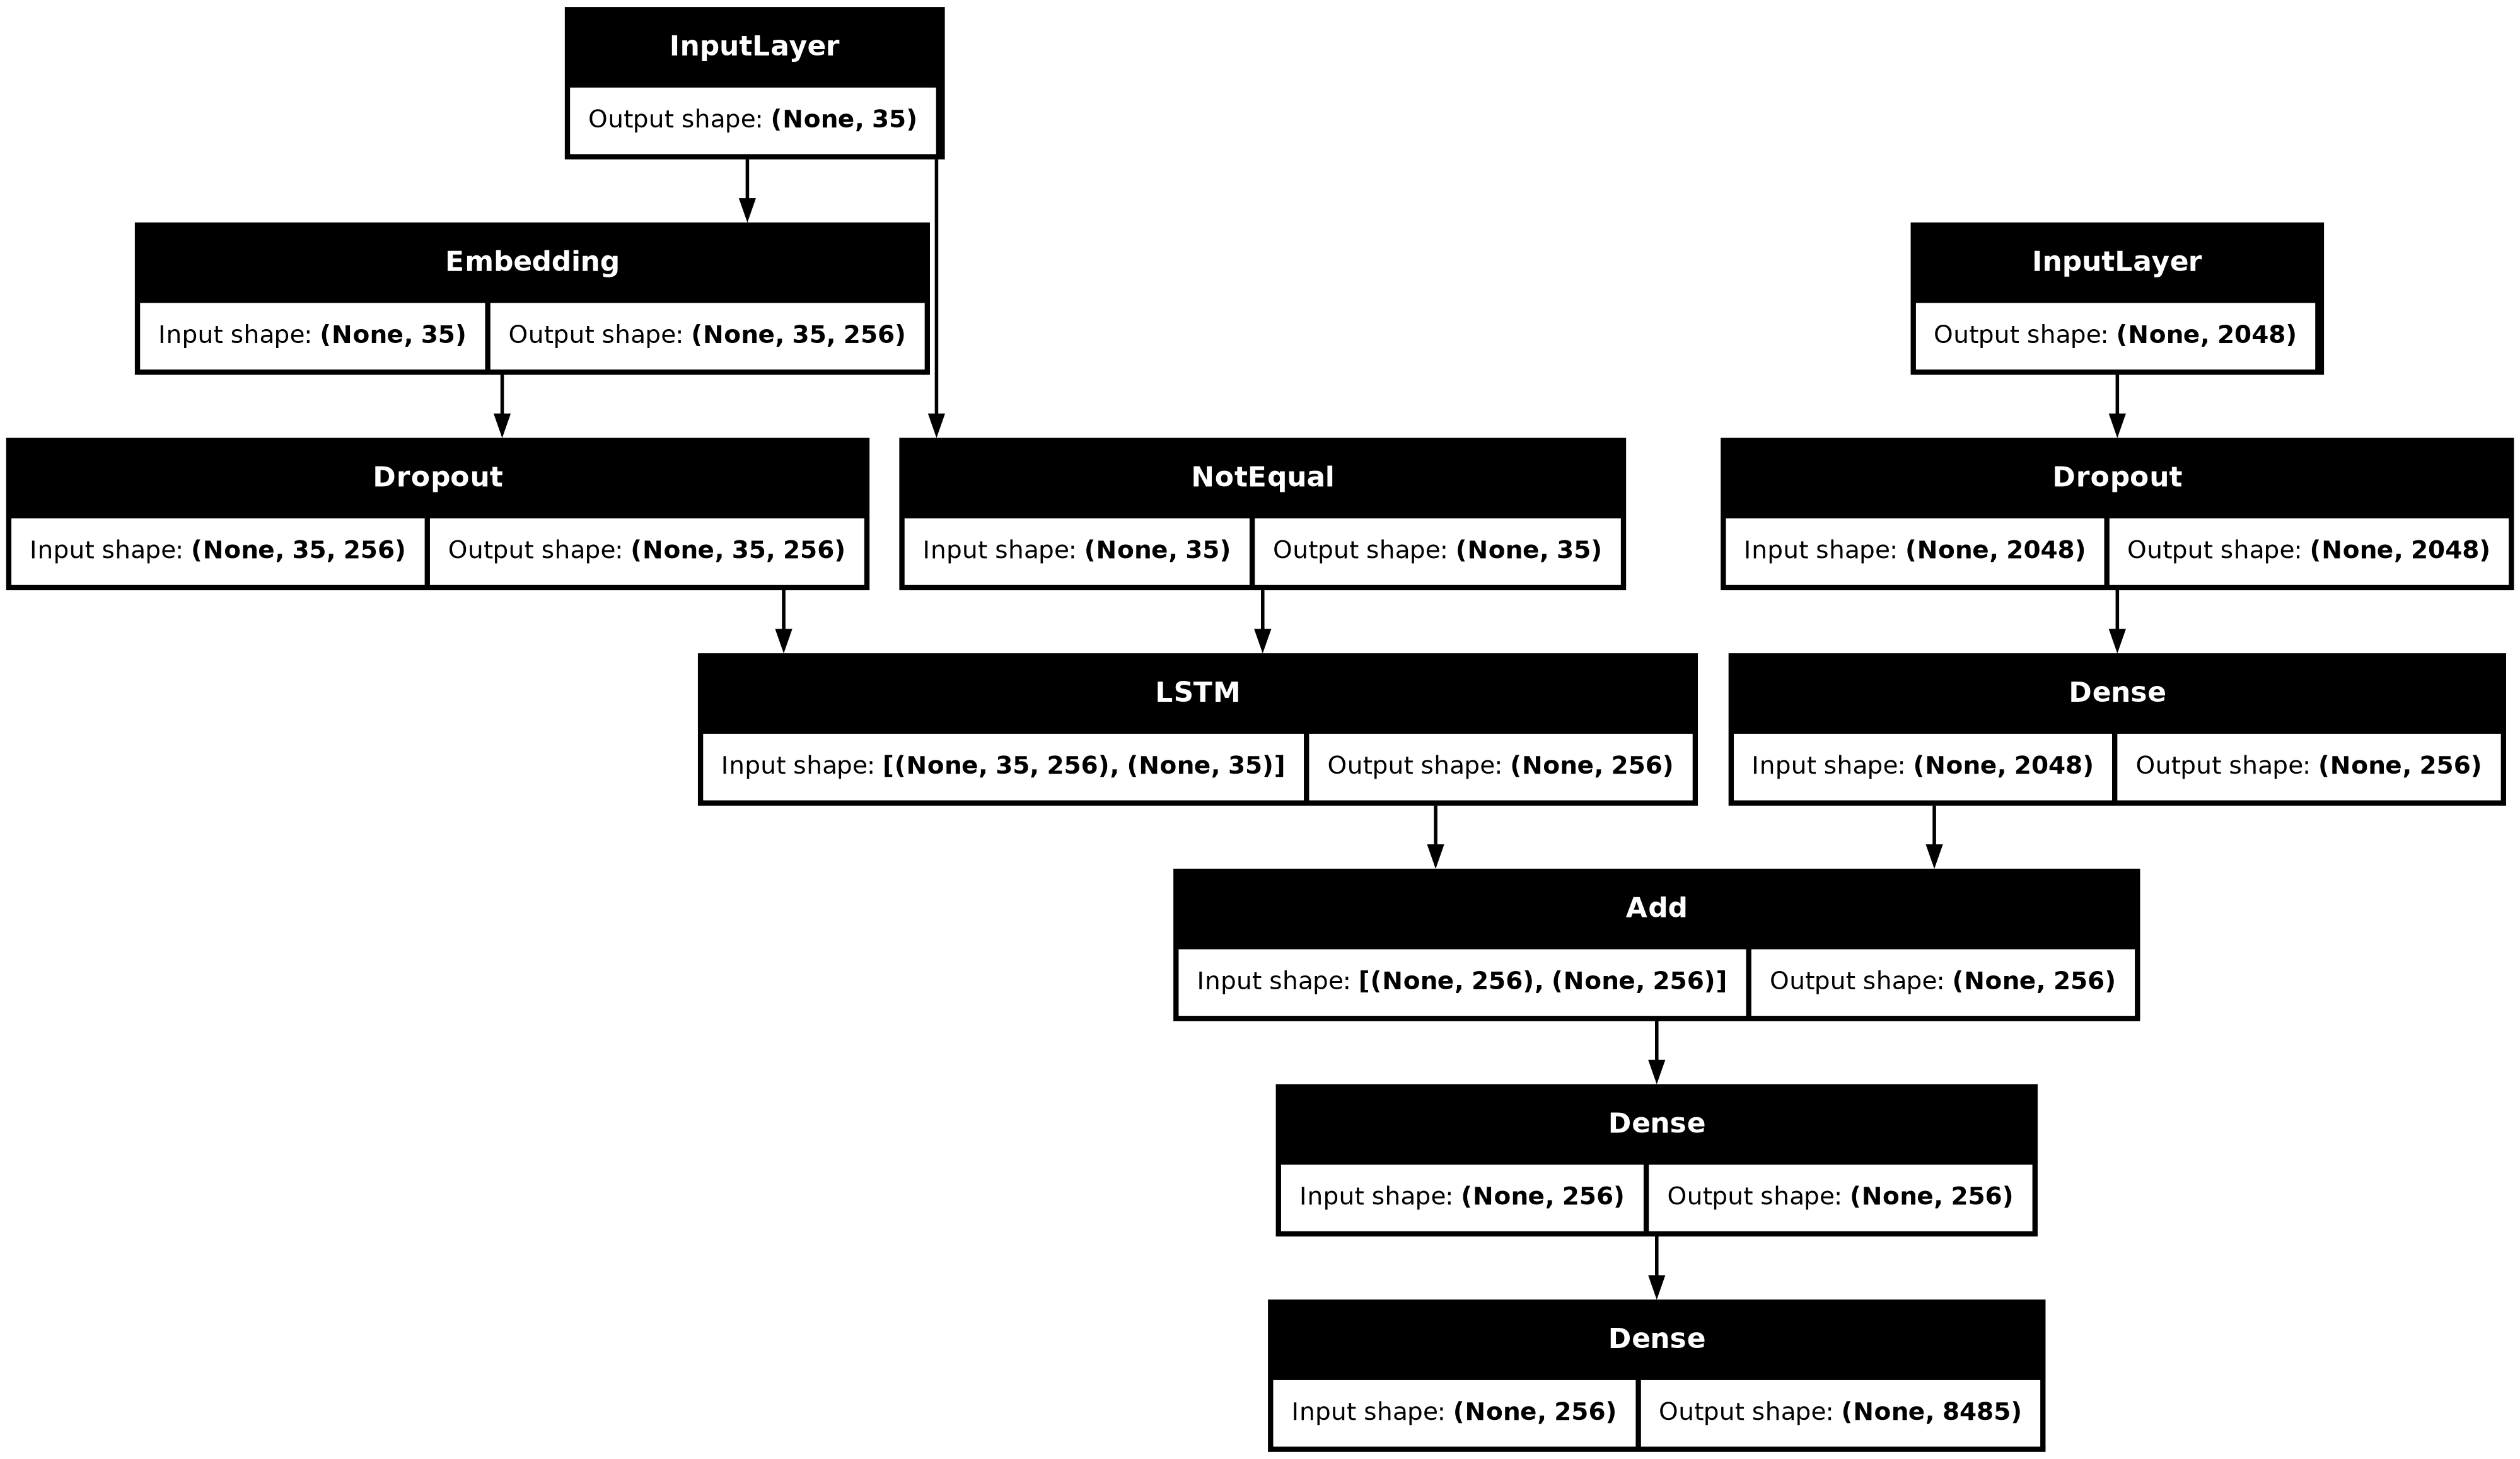

In [24]:
import pydot
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder mpdel
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

model.compile(optimizer='adam', loss='categorical_crossentropy')
# lstm_layer = LSTM(units=128, return_sequences = True, recurrent_activation='sigmoid')
# print(len(train) // batch_size)

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


    # dataset = tf.data.Dataset.from_generator(lambda: generator, output_signature=((tf.TensorSpec(shape=(None, 4096)), tf.TensorSpec(shape=(None, max_length))), tf.TensorSpec(shape=(None, vocab_size))))

I0000 00:00:1726483515.682831  133006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  1/113 ━━━━━━━━━━━━━━━━━━━━ 26:27 14s/step - loss: 9.0560

I0000 00:00:1726483526.269616  133019 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  2/113 ━━━━━━━━━━━━━━━━━━━━ 19:32 11s/step - loss: 9.0067

I0000 00:00:1726483537.212137  133037 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  3/113 ━━━━━━━━━━━━━━━━━━━━ 19:43 11s/step - loss: 8.9438

I0000 00:00:1726483547.718939  133049 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  4/113 ━━━━━━━━━━━━━━━━━━━━ 19:22 11s/step - loss: 8.8607

I0000 00:00:1726483559.004877  133066 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  5/113 ━━━━━━━━━━━━━━━━━━━━ 19:31 11s/step - loss: 8.7537

I0000 00:00:1726483569.673685  133079 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  6/113 ━━━━━━━━━━━━━━━━━━━━ 19:15 11s/step - loss: 8.6301

I0000 00:00:1726483581.265651  133094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  7/113 ━━━━━━━━━━━━━━━━━━━━ 19:17 11s/step - loss: 8.5075

I0000 00:00:1726483592.793525  133111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  8/113 ━━━━━━━━━━━━━━━━━━━━ 19:16 11s/step - loss: 8.3948

I0000 00:00:1726483603.919081  133126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



  9/113 ━━━━━━━━━━━━━━━━━━━━ 19:06 11s/step - loss: 8.2911

I0000 00:00:1726483614.645340  133139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 10/113 ━━━━━━━━━━━━━━━━━━━━ 18:51 11s/step - loss: 8.1993

I0000 00:00:1726483622.717596  133155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726483626.383274  133157 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 11/113 ━━━━━━━━━━━━━━━━━━━━ 18:48 11s/step - loss: 8.1141

I0000 00:00:1726483636.761361  133170 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 12/113 ━━━━━━━━━━━━━━━━━━━━ 18:32 11s/step - loss: 8.0362

I0000 00:00:1726483647.771690  133187 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 13/113 ━━━━━━━━━━━━━━━━━━━━ 18:20 11s/step - loss: 7.9647

I0000 00:00:1726483658.534851  133202 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 14/113 ━━━━━━━━━━━━━━━━━━━━ 18:07 11s/step - loss: 7.8991

I0000 00:00:1726483669.994050  133215 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 15/113 ━━━━━━━━━━━━━━━━━━━━ 17:59 11s/step - loss: 7.8382

I0000 00:00:1726483680.931073  133231 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 16/113 ━━━━━━━━━━━━━━━━━━━━ 17:48 11s/step - loss: 7.7816

I0000 00:00:1726483691.997455  133245 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 17/113 ━━━━━━━━━━━━━━━━━━━━ 17:37 11s/step - loss: 7.7291

I0000 00:00:1726483703.718560  133261 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 18/113 ━━━━━━━━━━━━━━━━━━━━ 17:30 11s/step - loss: 7.6798

I0000 00:00:1726483715.235190  133275 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 19/113 ━━━━━━━━━━━━━━━━━━━━ 17:21 11s/step - loss: 7.6337

I0000 00:00:1726483727.209060  133289 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 20/113 ━━━━━━━━━━━━━━━━━━━━ 17:15 11s/step - loss: 7.5902

I0000 00:00:1726483738.785511  133305 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 21/113 ━━━━━━━━━━━━━━━━━━━━ 17:05 11s/step - loss: 7.5492

I0000 00:00:1726483749.233124  133320 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 22/113 ━━━━━━━━━━━━━━━━━━━━ 16:51 11s/step - loss: 7.5104

I0000 00:00:1726483760.497411  133337 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 23/113 ━━━━━━━━━━━━━━━━━━━━ 16:41 11s/step - loss: 7.4733

I0000 00:00:1726483771.071787  133349 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 24/113 ━━━━━━━━━━━━━━━━━━━━ 16:28 11s/step - loss: 7.4376

I0000 00:00:1726483779.540216  133366 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726483782.071007  133367 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 25/113 ━━━━━━━━━━━━━━━━━━━━ 16:16 11s/step - loss: 7.4037

I0000 00:00:1726483793.812072  133379 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 26/113 ━━━━━━━━━━━━━━━━━━━━ 16:07 11s/step - loss: 7.3713

I0000 00:00:1726483804.327590  133397 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 27/113 ━━━━━━━━━━━━━━━━━━━━ 15:54 11s/step - loss: 7.3403

I0000 00:00:1726483815.310387  133411 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 28/113 ━━━━━━━━━━━━━━━━━━━━ 15:43 11s/step - loss: 7.3110

I0000 00:00:1726483826.156418  133425 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 29/113 ━━━━━━━━━━━━━━━━━━━━ 15:31 11s/step - loss: 7.2831

I0000 00:00:1726483836.769718  133440 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 30/113 ━━━━━━━━━━━━━━━━━━━━ 15:18 11s/step - loss: 7.2563

I0000 00:00:1726483847.849619  133457 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 31/113 ━━━━━━━━━━━━━━━━━━━━ 15:08 11s/step - loss: 7.2303

I0000 00:00:1726483857.149703  133469 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726483858.586395  133471 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 32/113 ━━━━━━━━━━━━━━━━━━━━ 14:55 11s/step - loss: 7.2054

I0000 00:00:1726483869.474038  133485 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 33/113 ━━━━━━━━━━━━━━━━━━━━ 14:44 11s/step - loss: 7.1813

I0000 00:00:1726483880.727775  133502 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 34/113 ━━━━━━━━━━━━━━━━━━━━ 14:34 11s/step - loss: 7.1582

I0000 00:00:1726483891.868260  133515 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 35/113 ━━━━━━━━━━━━━━━━━━━━ 14:22 11s/step - loss: 7.1359

I0000 00:00:1726483899.949641  133531 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726483903.467838  133529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 36/113 ━━━━━━━━━━━━━━━━━━━━ 14:12 11s/step - loss: 7.1142

I0000 00:00:1726483914.047914  133544 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 37/113 ━━━━━━━━━━━━━━━━━━━━ 14:00 11s/step - loss: 7.0932

I0000 00:00:1726483925.410473  133562 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 38/113 ━━━━━━━━━━━━━━━━━━━━ 13:50 11s/step - loss: 7.0728

I0000 00:00:1726483936.440070  133575 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 39/113 ━━━━━━━━━━━━━━━━━━━━ 13:39 11s/step - loss: 7.0532

I0000 00:00:1726483947.203840  133590 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 40/113 ━━━━━━━━━━━━━━━━━━━━ 13:27 11s/step - loss: 7.0341

I0000 00:00:1726483957.665957  133607 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 42/113 ━━━━━━━━━━━━━━━━━━━━ 12:45 11s/step - loss: 6.9980

I0000 00:00:1726483968.607156  133620 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 44/113 ━━━━━━━━━━━━━━━━━━━━ 12:07 11s/step - loss: 6.9638

I0000 00:00:1726483979.926344  133636 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 45/113 ━━━━━━━━━━━━━━━━━━━━ 11:57 11s/step - loss: 6.9474

I0000 00:00:1726483990.608342  133652 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 47/113 ━━━━━━━━━━━━━━━━━━━━ 11:21 10s/step - loss: 6.9160

I0000 00:00:1726484001.487405  133666 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 48/113 ━━━━━━━━━━━━━━━━━━━━ 11:11 10s/step - loss: 6.9009

I0000 00:00:1726484012.563686  133679 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 49/113 ━━━━━━━━━━━━━━━━━━━━ 11:02 10s/step - loss: 6.8861

I0000 00:00:1726484024.135650  133696 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 50/113 ━━━━━━━━━━━━━━━━━━━━ 10:53 10s/step - loss: 6.8717

I0000 00:00:1726484034.804755  133709 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 51/113 ━━━━━━━━━━━━━━━━━━━━ 10:43 10s/step - loss: 6.8576

I0000 00:00:1726484045.940351  133726 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 52/113 ━━━━━━━━━━━━━━━━━━━━ 10:34 10s/step - loss: 6.8439

I0000 00:00:1726484056.603696  133742 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 53/113 ━━━━━━━━━━━━━━━━━━━━ 10:24 10s/step - loss: 6.8306

I0000 00:00:1726484067.183746  133754 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 54/113 ━━━━━━━━━━━━━━━━━━━━ 10:13 10s/step - loss: 6.8176

I0000 00:00:1726484078.391720  133770 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 55/113 ━━━━━━━━━━━━━━━━━━━━ 10:04 10s/step - loss: 6.8048

I0000 00:00:1726484086.852014  133786 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484088.947805  133784 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 56/113 ━━━━━━━━━━━━━━━━━━━━ 9:54 10s/step - loss: 6.7924 

I0000 00:00:1726484097.705352  133802 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484099.457904  133800 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 57/113 ━━━━━━━━━━━━━━━━━━━━ 9:43 10s/step - loss: 6.7802

I0000 00:00:1726484110.574823  133816 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 58/113 ━━━━━━━━━━━━━━━━━━━━ 9:34 10s/step - loss: 6.7684

I0000 00:00:1726484121.542418  133829 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 60/113 ━━━━━━━━━━━━━━━━━━━━ 9:04 10s/step - loss: 6.7456

I0000 00:00:1726484132.316519  133847 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 61/113 ━━━━━━━━━━━━━━━━━━━━ 8:54 10s/step - loss: 6.7346

I0000 00:00:1726484143.363930  133861 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 62/113 ━━━━━━━━━━━━━━━━━━━━ 8:44 10s/step - loss: 6.7237

I0000 00:00:1726484153.832683  133875 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 63/113 ━━━━━━━━━━━━━━━━━━━━ 8:34 10s/step - loss: 6.7132

I0000 00:00:1726484164.971126  133890 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 64/113 ━━━━━━━━━━━━━━━━━━━━ 8:25 10s/step - loss: 6.7029

I0000 00:00:1726484172.686487  133905 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484176.498997  133906 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 65/113 ━━━━━━━━━━━━━━━━━━━━ 8:15 10s/step - loss: 6.6928

I0000 00:00:1726484187.115370  133922 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 67/113 ━━━━━━━━━━━━━━━━━━━━ 7:48 10s/step - loss: 6.6731

I0000 00:00:1726484198.021073  133936 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 68/113 ━━━━━━━━━━━━━━━━━━━━ 7:38 10s/step - loss: 6.6635

I0000 00:00:1726484209.805262  133950 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 69/113 ━━━━━━━━━━━━━━━━━━━━ 7:29 10s/step - loss: 6.6541

I0000 00:00:1726484221.469136  133967 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 70/113 ━━━━━━━━━━━━━━━━━━━━ 7:19 10s/step - loss: 6.6449

I0000 00:00:1726484228.964917  133982 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484232.635882  133980 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 71/113 ━━━━━━━━━━━━━━━━━━━━ 7:10 10s/step - loss: 6.6358

I0000 00:00:1726484243.655116  133994 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 72/113 ━━━━━━━━━━━━━━━━━━━━ 7:00 10s/step - loss: 6.6269

I0000 00:00:1726484251.197289  134012 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484254.533808  134010 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 73/113 ━━━━━━━━━━━━━━━━━━━━ 6:50 10s/step - loss: 6.6182

I0000 00:00:1726484262.511515  134024 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484266.102646  134025 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 74/113 ━━━━━━━━━━━━━━━━━━━━ 6:40 10s/step - loss: 6.6096

I0000 00:00:1726484277.245908  134040 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 75/113 ━━━━━━━━━━━━━━━━━━━━ 6:31 10s/step - loss: 6.6011

I0000 00:00:1726484285.729182  134055 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484288.173561  134056 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 76/113 ━━━━━━━━━━━━━━━━━━━━ 6:21 10s/step - loss: 6.5928

I0000 00:00:1726484299.559382  134070 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 77/113 ━━━━━━━━━━━━━━━━━━━━ 6:11 10s/step - loss: 6.5846

I0000 00:00:1726484310.227823  134086 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 78/113 ━━━━━━━━━━━━━━━━━━━━ 6:01 10s/step - loss: 6.5765

I0000 00:00:1726484320.829434  134102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 80/113 ━━━━━━━━━━━━━━━━━━━━ 5:36 10s/step - loss: 6.5607

I0000 00:00:1726484331.609961  134115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 81/113 ━━━━━━━━━━━━━━━━━━━━ 5:26 10s/step - loss: 6.5530

I0000 00:00:1726484343.378345  134130 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 82/113 ━━━━━━━━━━━━━━━━━━━━ 5:16 10s/step - loss: 6.5453

I0000 00:00:1726484353.898431  134146 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 84/113 ━━━━━━━━━━━━━━━━━━━━ 4:52 10s/step - loss: 6.5303

I0000 00:00:1726484364.733763  134161 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 85/113 ━━━━━━━━━━━━━━━━━━━━ 4:43 10s/step - loss: 6.5229

I0000 00:00:1726484373.636815  134176 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484375.696226  134175 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 86/113 ━━━━━━━━━━━━━━━━━━━━ 4:33 10s/step - loss: 6.5156

I0000 00:00:1726484387.314287  134192 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 87/113 ━━━━━━━━━━━━━━━━━━━━ 4:23 10s/step - loss: 6.5084

I0000 00:00:1726484397.837553  134204 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 88/113 ━━━━━━━━━━━━━━━━━━━━ 4:13 10s/step - loss: 6.5013

I0000 00:00:1726484408.243841  134220 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 89/113 ━━━━━━━━━━━━━━━━━━━━ 4:03 10s/step - loss: 6.4943

I0000 00:00:1726484418.712351  134236 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 91/113 ━━━━━━━━━━━━━━━━━━━━ 3:40 10s/step - loss: 6.4805

I0000 00:00:1726484429.647621  134249 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 92/113 ━━━━━━━━━━━━━━━━━━━━ 3:30 10s/step - loss: 6.4738

I0000 00:00:1726484440.339972  134267 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 93/113 ━━━━━━━━━━━━━━━━━━━━ 3:21 10s/step - loss: 6.4671

I0000 00:00:1726484451.824484  134281 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 94/113 ━━━━━━━━━━━━━━━━━━━━ 3:11 10s/step - loss: 6.4605

I0000 00:00:1726484461.027074  134296 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484462.544590  134294 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 95/113 ━━━━━━━━━━━━━━━━━━━━ 3:01 10s/step - loss: 6.4540

I0000 00:00:1726484473.175614  134309 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 96/113 ━━━━━━━━━━━━━━━━━━━━ 2:51 10s/step - loss: 6.4475

I0000 00:00:1726484483.832129  134325 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



 99/113 ━━━━━━━━━━━━━━━━━━━━ 2:18 10s/step - loss: 6.4285

I0000 00:00:1726484495.966350  134340 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



101/113 ━━━━━━━━━━━━━━━━━━━━ 1:57 10s/step - loss: 6.4162

I0000 00:00:1726484507.381280  134354 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



102/113 ━━━━━━━━━━━━━━━━━━━━ 1:48 10s/step - loss: 6.4101

I0000 00:00:1726484517.915327  134369 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



103/113 ━━━━━━━━━━━━━━━━━━━━ 1:38 10s/step - loss: 6.4041

I0000 00:00:1726484525.605210  134385 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726484529.988791  134387 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



104/113 ━━━━━━━━━━━━━━━━━━━━ 1:28 10s/step - loss: 6.3981

I0000 00:00:1726484540.534512  134401 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



105/113 ━━━━━━━━━━━━━━━━━━━━ 1:18 10s/step - loss: 6.3922

I0000 00:00:1726484551.181275  134417 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



107/113 ━━━━━━━━━━━━━━━━━━━━ 58s 10s/step - loss: 6.3805 

I0000 00:00:1726484562.539984  134431 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



108/113 ━━━━━━━━━━━━━━━━━━━━ 48s 10s/step - loss: 6.3747

I0000 00:00:1726484573.167863  134447 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



111/113 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - loss: 6.3577

I0000 00:00:1726484584.341026  134462 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



112/113 ━━━━━━━━━━━━━━━━━━━━ 9s 10s/step - loss: 6.3521 

I0000 00:00:1726484595.437530  134476 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 1764 bytes spill stores, 1764 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 1094s 10s/step - loss: 6.3412
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - loss: 4.6338
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - loss: 3.9469
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 462ms/step - loss: 3.6419
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - loss: 3.4460
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - loss: 3.2934
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 462ms/step - loss: 3.1743
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - loss: 3.0734
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - loss: 2.9909
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - loss: 2.9203
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - loss: 2.8570
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - loss: 2.7977
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - loss: 2.7377
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - loss: 2.6821
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - loss: 2.6368
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - loss: 2.5923
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - loss: 2.55

In [27]:
# save the model
model.save("/kaggle/working/model.h5")

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
# generate caption for an Image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to eord
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
            
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()

    return final_caption

In [30]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLUE score
print("BLUE-1 : %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLUE-2 : %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLUE-1 : 0.577807
BLUE-2 : 0.355421


In [40]:
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Check if the image name is provided
    if not image_name or not isinstance(image_name, str):
        print("Error: Image name must be a non-empty string.")
        return

    # Check if the image has a valid extension
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    if not any(image_name.lower().endswith(ext) for ext in valid_extensions):
        print("Error: Invalid image format. Supported formats are: jpg, jpeg, png, bmp, gif.")
        return

    # Generate the image path
    img_path = os.path.join("/kaggle/input/flickr-8k-images-with-captions/Images", image_name)

    # Check if the image file exists
    if not os.path.exists(img_path):
        print(f"Error: The file '{image_name}' does not exist at the specified path.")
        return

    try:
        # Load the image
        image = Image.open(img_path)
    except Exception as e:
        print(f"Error: Could not open the image. Details: {e}")
        return

    # Extract the image ID
    image_id = image_name.split('.')[0]

    # Check if captions are available for the image
    captions = mapping.get(image_id)
    if captions:
        print('-------------------Actual---------------------')
        for caption in captions:
            print(caption)
    else:
        print('No captions available for this image.')

    # Predict the caption
    try:
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('----------------Predicted---------------------')
        print(y_pred)
    except Exception as e:
        print(f"Error: Failed to predict the caption. Details: {e}")
        return

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

-------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
----------------Predicted---------------------
man wearing black shirt and hat is wearing blitz hat


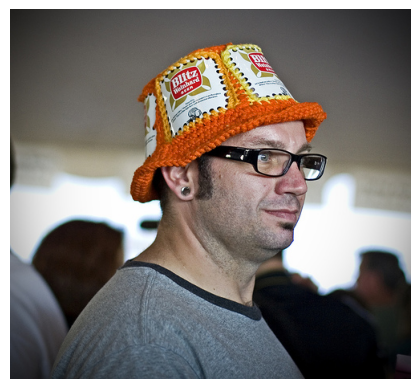

In [41]:
generate_caption("1007129816_e794419615.jpg")

-------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
----------------Predicted---------------------
two girls are playing on rope


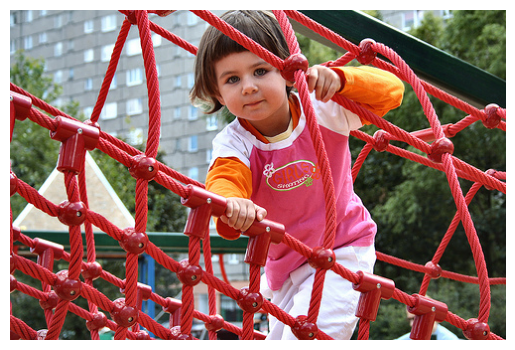

In [42]:
generate_caption("1007320043_627395c3d8.jpg")